In [ ]:
# !pip install pamda

In [1]:
# Finally I found a way to run fema_model on public device


!pip install gdown
folder_id = "1RMi5T81IxGm5d1h3qmzyTVWs906UXNwG"
!gdown --folder https://drive.google.com/drive/folders/{folder_id}
!pip install ./fema_model

Retrieving folder contents
Retrieving folder 1aXzqt8gbhAXr5gTR2XmaufDEEjsYZsFY fema_model
Retrieving folder 16MudXR66rmNrhsJuySCvCgnurrXlbfaq pycache
Processing file 1hygQY33K2n6QETrTwAF8lYnQAJQtzfn5 __init__.cpython-39.pyc
Processing file 12qQZzS-OyrwO7JYa5NYmXaqewjU-C95i cave_des.cpython-39.pyc
Processing file 1-lNyCw2dIOcYyfWCYjdjZKu4ixPGp_OV model.cpython-39.pyc
Processing file 1OxwwZmv1ljdcJ7bSK5zs9feh0RnAd85D __init__.py
Processing file 14Z3swFVuPYbuK-r0GGw_22j3r7GD0iFK cave_des.py
Processing file 12xp4ntG9wCR3Paral1gGOQVHe5L155je model.py
Retrieving folder 1VlpTw5CYZiNhSKh4oIP3P_D2bC2kokL4 fema_model.egg-info
Processing file 1379Q52tB-6WUAzBVf7U1n8-aHSWLWNOi __init__.cpython-39.pyc
Processing file 121aKgwNvxHNnlYF_i-vh88-JKgrfdKXf PKG-INFO
Processing file 1QJfiJKigkvIFC0D8V8R00e7RJ__wxpL6 requires.txt
Processing file 1KA7MTxaErtRB4eG9GpBnTiEE8l3xA5dh SOURCES.txt
Processing file 1hSSVd39qQmSeEMQdZ2FtEmSRL3GZm0EL top_level.txt
Processing file 1jIYl5AaCZMzb-KOPe9n83bf1hrbDSdxH setu

In [ ]:
# from google.colab import drive
# drive.mount('fema-fl-data-SR_Branch')

In [ ]:
# !pip install /content/fema-fl-data-SR_Branch/MyDrive/GitHub/fema-fl-data-SR_Branch/fema_model

In [2]:
from pamda import pamda as p
from fema_model import Multi_Period_Terminal_System
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm


In [3]:
geo_areas = p.read_json('geo_areas.json')

In [4]:
groups_df = pd.read_excel('NMSZ_Groups.xlsx')
groups = groups_df['group_name'].values
terminals_df = pd.read_excel('NMSZ_Terminals.xlsx')
stations_df = pd.read_excel('NMSZ_Stations.xlsx')

In [5]:
# Fixed parameters
# Bay queue space
b_q = 3
# Time to empty fuel at station (mins)
r_s = 60
# Bounds of time to empty fuel at station (mins)
r_s_bound = 10
# Truck start time max (hrs)
a = 6
# Truck capacity (gallons)
c = 9000
# Truck stopping criteria (hr)
tau = 0.5

# Flexible parameters
# Gate check-in time (mins)
# Baseline
r_g = 7
# Disruption
# r_g = 10.5
# r_g = 8.4
# Intervention
# r_g = 3.5
# Bounds multiplier of gate check-in time (mins)
r_g_bound = 0.1
# Bay filling time (mins)
# Baseline
r_b = 35
# Disruption
# r_b = 52.5
# r_b = 42
# Intervention
# r_b = 17.5
# Bounds multiplier of bay filling time (mins)
r_b_bound = 0.1
# Truck speed (mph)
# Baseline
v = 45
# Disruption
# v = 22.5
# v = 36
# Intervention
# v = 67.5
# Bounds multiplier of truck speed (mph)
v_bound = 0.1
# Hours of service (hrs)
# Baseline
h = 14
# HoS extension
# h = 18

# Iterations
itrn = 50

# Final outputs for all groups
ops_df = pd.DataFrame(columns = ['Iteration', 'Group', 'Flow', 'Flow_MMgal', 'Trips_Per_Truck', 'Gate_Queue_Wait', 'Driving_Time'])

# Input kwargs
inputs = {
    'carry_over_demand_multiplier':0,
    'default_kwargs':{
        'demand_situation':'dem_scen_1',
        'demand_multiplier':1,
        'truck_multiplier':1,
        'station_algorithm':'max',
        'truck_kwargs':{
            'size':c,
            'speed':v,
            'speed_sigma':v*v_bound,
            'empty_rate':r_s,
            'empty_rate_sigma':r_s_bound,
            'open_time_min':0,
            'open_time_max':a,
            'close_time_after_open':h,
            'close_early_delta':tau
        },
        'station_kwargs':{
            'open_time':0,
            'close_time':24,
        },
        'terminal_kwargs':{
            'gate_kwargs':{
                'gate_rate':r_g,
                'gate_rate_sigma':r_g*r_g_bound,
                'open_time':0,
                'close_time':24,
                'extra_gates':0,
                'max_gate_queue':None, #Infinite
                'share_gate_queue_bool':True
            },
            'bay_kwargs':{
                'open_time':0,
                'close_time':24,
                'fill_rate':r_b,
                'fill_rate_sigma':r_b*r_b_bound,
                'extra_bays':0,
                'max_bay_queue':b_q,
                'share_bay_queue_bool':True
            }
        }
    }
}

# Selected terminal interventions
inputs['terminal_kwargs'] = {}

# Create terminal systems dictionary
terminal_system_data = {}
for i in range(len(groups)):
    terminal_system_data[groups[i]] = {}
    # Baseline
    terminal_system_data[groups[i]]['trucks_available'] = int(groups_df['trucks'][i])
    # Disruption
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.5))
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.8))
    # Fixed fleet intervention
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.5))+20
    # Fleet intervention
    # terminal_system_data[groups[i]]['trucks_available'] = int(np.ceil(groups_df['trucks'][i]*0.75))
    terms = terminals_df[terminals_df['group_name'] == groups[i]]['terminal_id'].values
    terminal_system_data[groups[i]]['terminals'] = {}
    for j in range(len(terms)):
        terminal_system_data[groups[i]]['terminals'][terms[j]] = {}
        terminal_system_data[groups[i]]['terminals'][terms[j]]['fuel_types'] = 'a'
        terminal_system_data[groups[i]]['terminals'][terms[j]]['num_gates'] = int(terminals_df[terminals_df['terminal_id'] == terms[j]]['num_gates'].values[0])
        terminal_system_data[groups[i]]['terminals'][terms[j]]['num_bays'] = int(terminals_df[terminals_df['terminal_id'] == terms[j]]['num_bays'].values[0])
        # Terminal interventions for 2 largest terminal in the group
        # if(j >= len(terms)-2):
        #     inputs['terminal_kwargs'][terms[j]] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs']['gate_rate'] = 3.5
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs']['fill_rate'] = 17.5
        # Terminal interventions for largest terminal in the group
        # if(j == len(terms)-1):
        #     inputs['terminal_kwargs'][terms[j]] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['gate_kwargs']['gate_rate'] = 3.5
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs'] = {}
        #     inputs['terminal_kwargs'][terms[j]]['bay_kwargs']['fill_rate'] = 17.5

for l in tqdm(range(itrn)):
    op_flow = np.zeros((len(groups),))
    op_trips = np.zeros((len(groups),))
    op_gate_wait = np.zeros((len(groups),))
    op_driving = np.zeros((len(groups),))
    for i in range(len(groups)):
        stn = stations_df[stations_df['group_name'] == groups[i]]
        stn = shuffle(stn).reset_index()
        terminal_system_data[groups[i]]['stations'] = {}
        for k in range(len(stn)):
            station_name = stn['station_id'][k]
            terminal_system_data[groups[i]]['stations'][station_name] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['travel_distance'] = stn['station_group_dist'][k]
            terminal_system_data[groups[i]]['stations'][station_name]['geo_code'] = '1'
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios'] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1'] = {}
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1']['demand'] = c
            terminal_system_data[groups[i]]['stations'][station_name]['demand_scenarios']['dem_scen_1']['fuel_types'] = ['a']
    periods = [inputs]
    model = Multi_Period_Terminal_System(terminal_system_data = terminal_system_data, geo_areas = geo_areas, periods = periods)
    output = model.serialize(minify = True)
    for i in range(len(groups)):
        op_flow[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['sum_met_total_demand']),3)
        op_trips[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_deliveries_made']),3)
        op_gate_wait[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['trip_avg_in_gate_queue']),3)
        op_driving[i] = round((output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_to_station'] +\
                               output['0']['terminal_groups'][groups[i]]['statistics']['truck_avg_to_terminal_group']),3)
    op_df1 = pd.DataFrame(columns = ['Iteration', 'Group', 'Flow', 'Flow_MMgal', 'Trips_Per_Truck', 'Gate_Queue_Wait', 'Driving_Time'])

    op_df1['Flow'] = op_flow
    op_df1['Flow_MMgal'] = op_flow/(10**6)
    op_df1['Trips_Per_Truck'] = op_trips
    op_df1['Gate_Queue_Wait'] = op_gate_wait
    op_df1['Driving_Time'] = op_driving
    op_df1['Iteration'] = l
    op_df1['Group'] = groups
    ops_df = pd.concat([ops_df, op_df1], ignore_index=True)

# Baseline
ops_df.to_csv('2024-12-17_NMSZ_No_Evansville_Results.csv')
# Gate intervention
# ops_df.to_csv('2024-12-25_NMSZ_No_Memphis_Results_Gate_intervention.csv')

# print("File saved as 2024-11-27_NMSZ_Baseline_Results.csv")
# Disruption
# ops_df.to_csv('2022-03-15_Florida_Disruption2_Results.csv')
# Disruption + HoS extension
# ops_df.to_csv('2022-03-15_Florida_Disruption2_HoS_Results.csv')
# Disruption + HoS extension + single terminal intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_1_Terminal_Results.csv')
# Disruption + HoS extension + two terminals intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_2_Terminals_Results.csv')
# Disruption + HoS extension + all terminals intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Terminals_Results.csv')
# Disruption + HoS extension + speed intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Speed_Results.csv')
# Disruption + HoS extension + fixed fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Fixed_Fleet_Results.csv')
# Disruption + HoS extension + fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Fleet_Results.csv')
# Disruption + HoS extension + speed + fleet intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_HoS_Speed_Fleet2_Results.csv')
# Disruption + all intervention
# ops_df.to_csv('2022-03-15_Florida_Disruption_All_Interventions2_Results.csv')

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-5-521c9d34a301>:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ops_df = pd.concat([ops_df, op_df1], ignore_index=True)
100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


In [6]:
print("File saved as 2024-12-25_NMSZ_No_Evansville_baseline_Results.csv")

File saved as 2024-12-25_NMSZ_No_Evansville_baseline_Results.csv


In [7]:
ops_df

,Iteration,Group,Flow,Flow_MMgal,Trips_Per_Truck,Gate_Queue_Wait,Driving_Time
0,0,Cape Girardeau,810000.0,0.810,2.308,0.076,4.943
1,0,Greenville,549000.0,0.549,2.542,0.015,4.727
2,0,Jonesboro,819000.0,0.819,2.395,0.033,5.348
3,0,Little Rock,2547000.0,2.547,2.620,0.000,4.644
4,0,Memphis,3357000.0,3.357,2.220,0.639,4.285
...,...,...,...,...,...,...,...
545,49,Paducah,702000.0,0.702,1.857,0.551,4.031
546,49,Princeton,306000.0,0.306,2.429,0.047,3.825
547,49,Robinson,423000.0,0.423,2.136,0.014,5.327
548,49,St. Louis,3384000.0,3.384,1.686,1.899,1.913


In [8]:
# Group by 'Group' and describe aggregated statistics
grouped_description = ops_df.groupby('Group').describe()

# Display the result
print(grouped_description)


                Flow                                                 \
               count       mean           std        min        25%   
Group                                                                 
Cape Girardeau  50.0   781920.0  32962.464738   702000.0   756000.0   
Greenville      50.0   507780.0  29267.443778   459000.0   486000.0   
Jonesboro       50.0   790740.0  33081.106267   711000.0   765000.0   
Little Rock     50.0  2558520.0  63014.167503  2457000.0  2511000.0   
Memphis         50.0  3284460.0  62364.697628  3177000.0  3242250.0   
Owensboro       50.0   716940.0  33359.764351   630000.0   693000.0   
Paducah         50.0   655020.0  27170.279381   585000.0   639000.0   
Princeton       50.0   315720.0  21424.799668   270000.0   297000.0   
Robinson        50.0   443340.0  23971.590328   396000.0   423000.0   
St. Louis       50.0  3403440.0  47705.371280  3303000.0  3370500.0   
Wood River      50.0   560340.0  32719.344587   504000.0   540000.0   

     

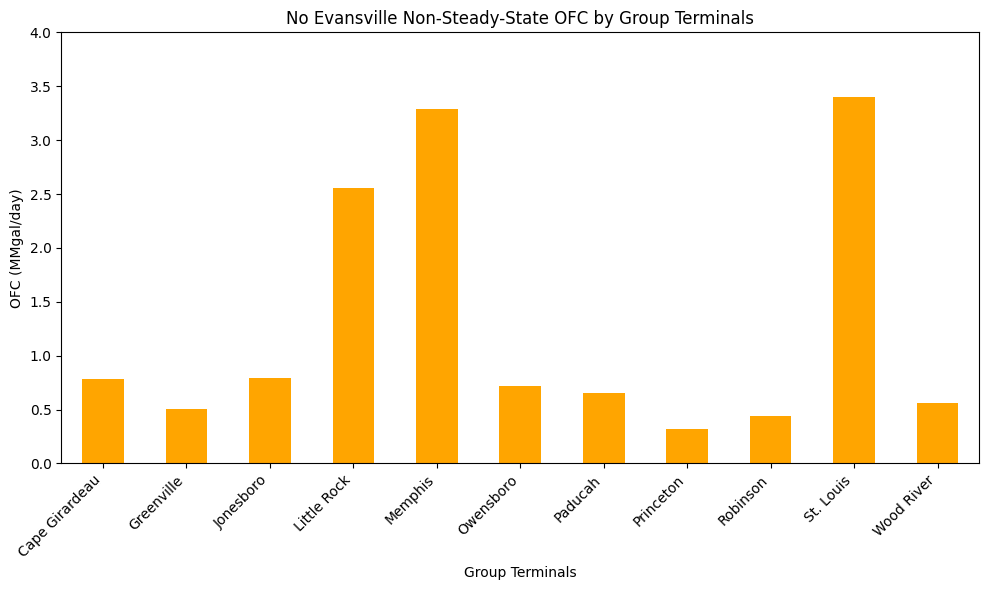

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Average of 'Flow' for each group
flow_avg = ops_df.groupby('Group')['Flow'].mean()


ax = flow_avg.plot(kind='bar', figsize=(10, 6), title='No Evansville Non-Steady-State OFC by Group Terminals', color='orange')
ax.set_ylabel('OFC (MMgal/day)')
ax.set_xlabel('Group Terminals')

# Custom tick formatting to display values in millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1_000_000:,.1f}'))  # Convert to millions and format to 1 decimal

# Set Y-axis limits
ax.set_ylim(0, 4000000)  # Set maximum Y-axis value to 6.5

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
